In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import os

path = '/kaggle/input/eye-disease/EYE DIS/Train'

images = []
labels = []

for Class_name in os.listdir(path):
    folder_path = os.path.join(path, Class_name)
    
    if os.path.isdir(folder_path):  # Ensure it's a directory
        for img in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img)
            images.append(img_path)
            labels.append(Class_name)

print(f"Total images: {len(images)}")
print(f"Total labels: {len(labels)}")
print(f"Sample image path: {images[0] if images else 'No images found'}")


Total images: 2154
Total labels: 2154
Sample image path: /kaggle/input/eye-disease/EYE DIS/Train/Macular edema/623.jpg


In [6]:
print('number of Images:', len(images))
print('number of Labels:', len(labels))

number of Images: 2154
number of Labels: 2154


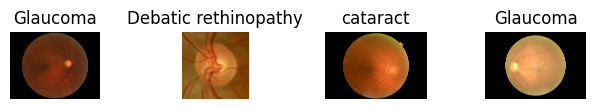

In [7]:
random_image_indices = random.sample(range(len(images)), 4)
plt.figure(figsize=(10, 4))
for i, index in enumerate(random_image_indices):
    img = cv2.imread(images[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(labels[index])
    plt.axis('off')
plt.show()

In [8]:
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = np.array(labels)
Y = to_categorical(labels, num_classes=4)

In [9]:
def load_and_preprocess_image(image_path):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # img = cv2.GaussianBlur(img, (5, 5), 0)    # Uncomment if you want to check use
  img = cv2.resize(img, (img_width, img_height))
  img = img / 255.0
  return img

In [12]:
X = []
img_width, img_height = 240, 240
for image in tqdm.tqdm(images):
  image = load_and_preprocess_image(image)
  X.append(image)

100%|██████████| 2154/2154 [02:12<00:00, 16.29it/s] 


In [13]:
from PIL import Image

def load_and_preprocess_image(image_path):
    try:
        img = Image.open(image_path)  # Use PIL instead of cv2
        img = img.convert("L")  # Convert to grayscale
        img = img.resize((img_width, img_height))  # Resize
        img = np.array(img) / 255.0  # Normalize
        return img
    except Exception as e:
        print(f"Error loading image: {image_path} → {e}")
        return None


In [14]:
X = np.array(X)
X = X.reshape(-1, img_width, img_height, 1) # adding a depth of 1

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
print(X_train.shape, X_test.shape)  # Should match input shape
print(y_train.shape, y_test.shape)  # Should match output shape

(1723, 240, 240, 1) (431, 240, 240, 1)
(1723, 4) (431, 4)


In [17]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [18]:
model=Sequential([
    Conv2D(32,(2,2),activation='relu',input_shape=(240, 240, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 239, 239, 32)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 119, 119, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 117, 117, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,938,212 (49.36 MB)

 Trainable params: 12,938,212 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 591ms/step - accuracy: 0.6598 - loss: 0.8372 - precision: 0.7199 - recall: 0.5016 - val_accuracy: 0.9814 - val_loss: 0.0615 - val_precision: 0.9814 - val_recall: 0.9814
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9560 - loss: 0.1428 - precision: 0.9560 - recall: 0.9560 - val_accuracy: 0.9768 - val_loss: 0.0481 - val_precision: 0.9768 - val_recall: 0.9768
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9625 - loss: 0.1064 - precision: 0.9632 - recall: 0.9606 - val_accuracy: 0.9930 - val_loss: 0.0247 - val_precision: 0.9953 - val_recall: 0.9930
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9791 - loss: 0.0608 - precision: 0.9791 - recall: 0.9788 - val_accuracy: 0.9907 - val_loss: 0.0320 - val_precision: 0.9907 - val_recall: 0.9907
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9823 - loss: 0.0574 - precision: 0.9823 - recall: 0.9790 - val_accuracy: 0.9977 - val_loss: 0.016

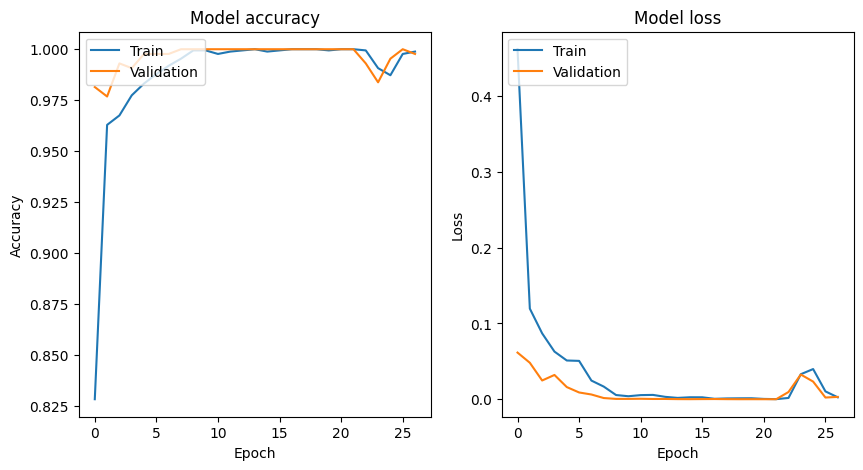

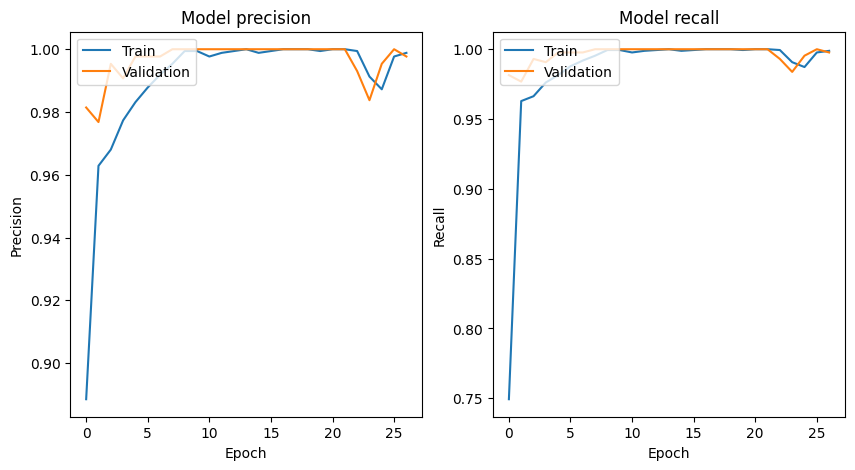

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation precision values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation recall values
plt.subplot(1, 2, 2)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
print("Predictions")
predictions = model.predict(X_test)
predicted_classes =  np.argmax(predictions , axis =1)
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

Predictions
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - loss: 1.4058e-05 - precision: 1.0000 - recall: 1.0000
Test Loss: 1.0594833838695195e-05
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0


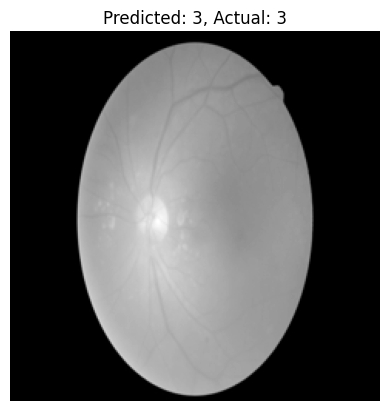

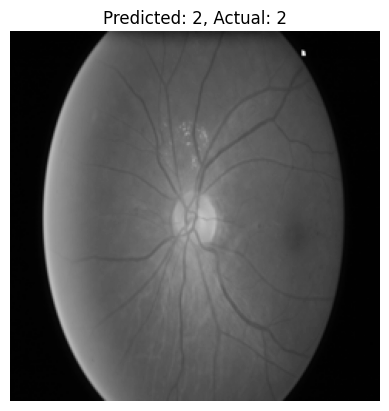

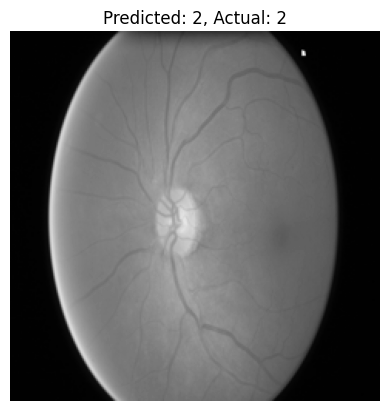

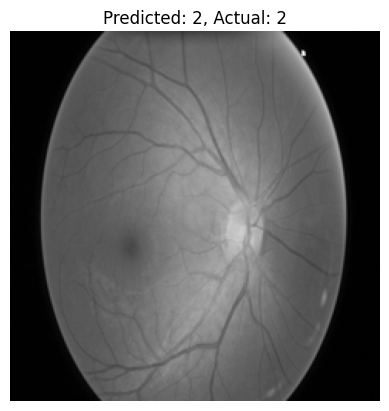

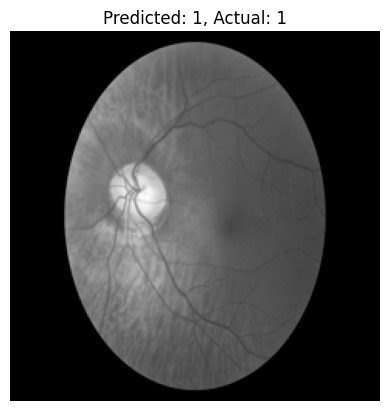

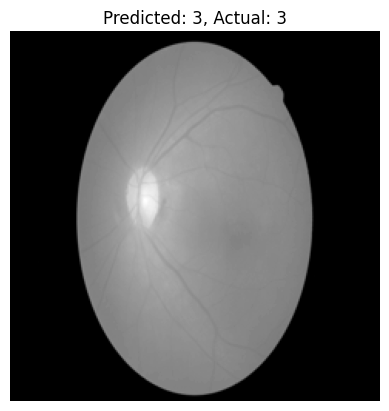

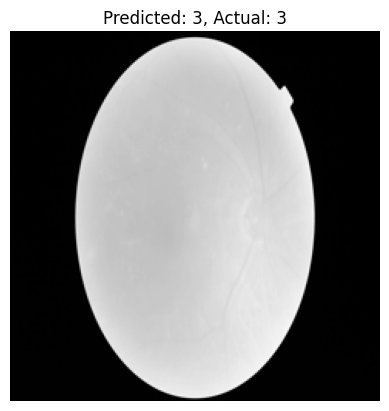

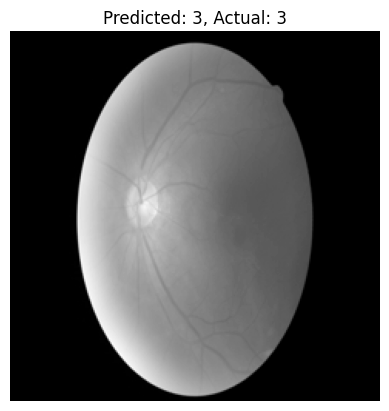

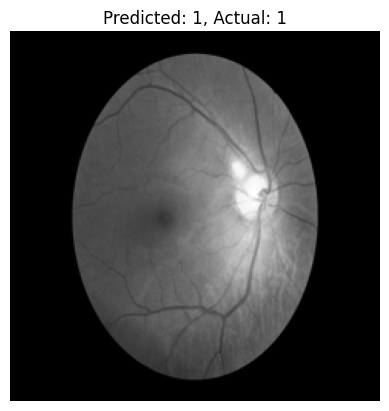

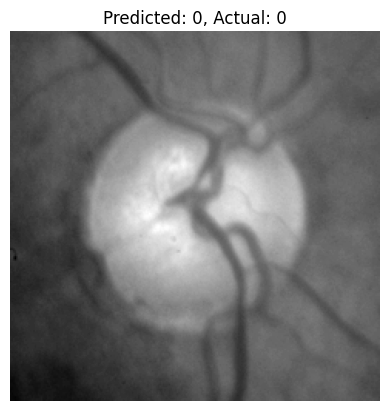

In [22]:
random_indices = random.sample(range(len(X_test)), 10)

for i in random_indices:
    img = X_test[i].reshape(240, 240)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) # Normalize for display

    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_classes[i]}, Actual: {np.argmax(y_test[i])}")
    plt.axis('off')
    plt.show()

In [23]:
model.save('EYE DISEASE MODEL 01.h5')